# Requirements

In [1]:
import pandas as pd
import numpy as np

import datetime
import pytz
import requests
from pandas.io.json import json_normalize

import pickle

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.linear_model import LinearRegression

# Dataset

In [2]:
IEX_API_URL_TEMPLATE = 'https://api.iextrading.com/1.0/stock/{}/chart/{}'

HIST_5Y = '5y'
HIST_1Y = '1y'
HIST_1M = '1m'

djia_tickers = [
    'BA',   'PFE', 'MCD', 'WMT', 'KO',   'MRK',  'HD',   'V',   'JNJ',  'VZ',
    'CSCO', 'AXP', 'TRV', 'DIS', 'MSFT', 'UNH',  'DWDP', 'CAT', 'AAPL', 'UTX',
    'MMM',  'JPM', 'IBM', 'GS',  'XOM',  'INTC', 'NKE',  'CVX', 'PG',   'WBA' ]

In [3]:
def expand_date(df):
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['week'] = df.date.dt.week
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayofyear'] = df.date.dt.dayofyear
    df['timestamp'] = df.date.values.astype(np.int64)

def format_dataset(df):
    formated_df = df.drop(['label',
                           'change', 'changeOverTime', 'changePercent',
                           'high', 'low', 'open',
                           'unadjustedVolume', 'volume', 'vwap'],
                          axis=1)

    expand_date(formated_df)
    return formated_df

def get_dataset_from_ticker(ticker_symbol, hist_period=HIST_5Y):
    r = requests.get(url = IEX_API_URL_TEMPLATE.format(ticker_symbol.lower(), hist_period))
    df = json_normalize(r.json())

    df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
    df.insert(loc=0, column='symbol', value=ticker_symbol)

    return format_dataset(df)


def get_djia_dataset(hist_period=HIST_5Y):
    df = None

    for ticker_symbol in djia_tickers:
        if df is None:
            df = get_dataset_from_ticker(ticker_symbol, hist_period=hist_period)
        else:
            df = df.append(get_dataset_from_ticker(ticker_symbol, hist_period))

    return df


def update_djia_dataset(djia_ds):
    last_recorded_day = max(djia_ds.date)
    today = datetime.datetime.now()
    days_to_update = (today - last_recorded_day).days

    hist_period = HIST_5Y

    if days_to_update < 1:
        return djia_ds
    elif days_to_update < 28:
        hist_period = HIST_1M
    elif days_to_update < 365:
        hist_period = HIST_1Y

    last_djia_ds = get_djia_dataset(hist_period)

    return djia_ds.append(last_djia_ds).drop_duplicates(['symbol', 'date'], keep='last')


def save_dataset_to_file(ds, file_name):
    with open(file_name, 'wb') as fp:
        pickle.dump(ds, fp)


def load_dataset_from_file(file_name):
    with open(file_name, 'rb') as fp:
        return pickle.load(fp)

# Trading days

In [4]:
market_holidays = []

def load_market_holidays(market_holidays_file='market_holidays.txt'):
    market_holidays.clear()

    with open(market_holidays_file) as f:
        lines = f.readlines()

    for line in lines:
        market_holidays.append(datetime.datetime.strptime(line.strip(), '%Y-%m-%d'))

load_market_holidays()

In [5]:
def is_trading_day(day):
    day_of_week = day.weekday()
    if day_of_week == 5 or day_of_week == 6 or day in market_holidays:
        return False
    else:
        return True


def get_trading_days_in_range(start_date, end_date):
    trading_days = []

    current_day = start_date
    while (current_day <= end_date):
        if is_trading_day(current_day):
            trading_days.append(current_day)
        current_day += datetime.timedelta(days=1)

    return trading_days

In [10]:
def str_to_datetime(str_date):
    return datetime.datetime.strptime(str_date, '%Y-%m-%d')

def datetime_array_to_dataframe(days):
    return pd.DataFrame({'date': days})

# Models

In [7]:
class StockForecasterModel:
    def __init__(self, ticker, dataset):
        self.ticker = ticker
        self.dataset = dataset

    def getDataset(self):
        return self.dataset

    def setDataset(self, dataset):
        self.dataset = dataset

    def train(self, start_date, end_date):
        raise NotImplementedError("Please Implement this method")

    def predict(self, from_date, to_date):
        raise NotImplementedError("Please Implement this method")

In [8]:
class LinearStockForecaster(StockForecasterModel):

    def __init__(self, ticker, dataset):
        StockForecasterModel.__init__(self, ticker, dataset)

    def train(self, start_date, end_date):
        training_set = self.dataset.query(
            "symbol == '{}' and date >= '{}' and date <= '{}'"
            .format(self.ticker, start_date, end_date))

        x = training_set.drop(['symbol', 'date', 'close'], axis=1)
        y = training_set.close

        self.model = LinearRegression()
        self.model.fit(x, y)

    def predict(self, from_date, to_date):
        days_to_predict = get_trading_days_in_range(from_date, to_date)
        x = datetime_array_to_dataframe(days_to_predict)
        expand_date(x)
        x = x.drop(['date'], axis=1)
        return self.model.predict(x)

In [11]:
djia_ds = load_dataset_from_file('data/djia_20140303-20190315.pkl')

m = LinearStockForecaster('AAPL', djia_ds)
m.train(str_to_datetime('2015-04-01'), str_to_datetime('2018-03-31'))
y = m.predict(str_to_datetime('2018-04-01'), str_to_datetime('2018-06-30'))

print(y)

[159.82152712 159.87194564 159.92236416 159.97278269 160.02320121
 160.17442758 160.2248461  160.27526462 160.32568315 160.37610167
 160.52732804 160.57774656 160.62816509 160.67858361 160.72900213
 160.8802285  160.93064702 160.98106555 161.03148407 161.08190259
 161.23312896 161.78087882 161.83129734 161.88171586 161.93213439
 162.08336075 162.13377928 162.1841978  162.23461632 162.28503485
 162.43626121 162.48667974 162.53709826 162.58751679 162.63793531
 162.78916167 162.8395802  162.88999872 162.94041725 162.99083577
 163.19248066 163.24289918 163.29331771 163.85762302 164.00884939
 164.05926791 164.10968644 164.16010496 164.21052349 164.36174985
 164.41216837 164.4625869  164.51300542 164.56342395 164.71465031
 164.76506884 164.81548736 164.86590588 164.91632441 165.06755077
 165.1179693  165.16838782 165.21880634 165.26922487]


# Analysis

In [16]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [51]:
def perform_test(dataset, ticker_symbol, model_constructor,
                 training_start, training_end,
                 validation_days=[1, 7, 15, 30, 60, 90, 180]):

    #validation_days = validation_days.sort()

    training_set = dataset.query("symbol == '{}' and date >= '{}' and date <= '{}'"
                                 .format(ticker_symbol, training_start, training_end))
    model = model_constructor(ticker_symbol, training_set)
    model.train(training_start, training_end)

    for v in validation_days:
        validation_start = training_end + datetime.timedelta(days=1)
        validation_end = validation_start + datetime.timedelta(days=v)
        validation_set = dataset.query("symbol == '{}' and date >= '{}' and date <= '{}'"
                                       .format(ticker_symbol, validation_start, validation_end))
        preds = model.predict(validation_start, validation_end)
        print('Validation {} day{}, RMSE = {}'.format(v, 's' if v != 1 else '', rmse(preds, validation_set.close)))
    
    plt.plot(training_set.date, training_set.close, label='Training')
    plt.plot(validation_set.date, validation_set.close, label='Validation')
    plt.plot(validation_set.date, preds, label='Prediction')

Validation 1 day, RMSE = 4.35837288419421
Validation 7 days, RMSE = 7.439487835284438
Validation 15 days, RMSE = 9.313557534392915
Validation 30 days, RMSE = 8.307899299327511
Validation 60 days, RMSE = 16.288076165018804
Validation 90 days, RMSE = 18.457619159387807
Validation 180 days, RMSE = 30.924583799668095


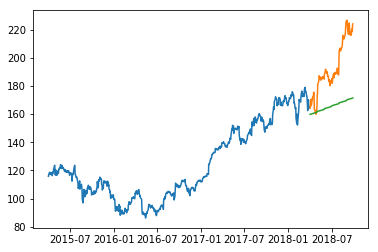

In [52]:
perform_test(djia_ds, 'AAPL', LinearStockForecaster,
             str_to_datetime('2015-04-01'), str_to_datetime('2018-03-31'))